# Diagnostics of FOCI-OpenIFS

In [15]:
# get the modules we need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [16]:
from dask.distributed import Client, LocalCluster, wait

In [17]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36239 instead
  expected, actual


In [18]:
client

Client Scheduler: tcp://127.0.0.1:34595 Dashboard: http://127.0.0.1:36239/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [19]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'
    oifs_area = '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK010/outdata/oifs/areacella.nc'

# Read NEMO grid

In [20]:
# NEMO mesh file has "z" as vertical coordinate
# but the grid_T files have "deptht" so we need to rename
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_dxt, da_orca05_dyt = ds_mesh['e1t'].sel(t=0), ds_mesh['e2t'].sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

In [21]:
## Read OpenIFS grid

In [22]:
ds_oifs = xr.open_dataset(oifs_area)
da_oifs_area = ds_oifs['areacella']

In [23]:
# global mean for NEMO T grid
def global_tmean(data):
    weights = da_orca05_area * da_orca05_mask
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('x','y'))
    
    return data_mean

def global_zonmean(data):
    weights = da_orca05_area * da_orca05_mask
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('x'))
    
    return data_mean

def global_tsum(data):
    area = da_orca05_area * da_orca05_mask
    data_a = (data * area).sum(('x','y'))
    return data_a

# global mean for OpeniFS
def global_mean(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('lon','lat'))
    
    return data_mean

def global_sum(data):
    area = da_oifs_area
    data_mean = (data * area).sum(('lon','lat'))
    return data_mean

## Read data

In [37]:
# Old continuation that did not work
#exp_list = ['FOCI_GJK001','FOCI_GJK001_cont']
#time_list = [slice('1850-01-01','3000-01-01'),slice('3000-01-01','3200-01-01')]

# Continue on berlin from year 4000
#exp_list = ['FOCI_GJK016']
#time_list = [slice('4000-01-01','5000-01-01')]
#version_list = [1]

exp_list = ['FOCI_GJK001','FOCI_GJK021','FOCI_GJK023','FOCI_GJK024']
time_list = [slice('1850-01-01','2200-01-01'), slice('1850-01-01','2200-01-01'),
             slice('1950-01-01','2200-01-01'), slice('1950-01-01','2200-01-01')]
version_list = [0, 1, 1, 1]

In [38]:
# OpenIFS surface
ds_sfc_all = []
for exp,time,ver in zip(exp_list,time_list,version_list):
    if ver == 1:
        sfc = '%s/%s/outdata/oifs/ym/*1y*regular_sfc.nc' % (esmdir,exp)
    elif ver == 0:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    
    # open multi-file data set. We need to use cftime since the normal python calendar stops working after 2300. 
    # also, we rename time variable from time_counter to time to make life easier
    # Optimized reading from Sebastian Wahl
    ds_sfc = xr.open_mfdataset(sfc,combine='nested', 
                               concat_dim="time_counter", use_cftime=True,
                               data_vars='minimal', coords='minimal', compat='override',
                               parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK021/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK023/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK024/outdata/oifs/ym/*1y*regular_sfc.nc


In [35]:
# OpenIFS surface
ds_sfc_1m_all = []
for exp,time,ver in zip(exp_list,time_list,version_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    
    # open multi-file data set. We need to use cftime since the normal python calendar stops working after 2300. 
    # also, we rename time variable from time_counter to time to make life easier
    ds_sfc = xr.open_mfdataset(sfc,combine='nested', 
                               concat_dim="time_counter", use_cftime=True,
                               data_vars='minimal', coords='minimal', compat='override',
                               parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1m_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK022/outdata/oifs/*1m*regular_sfc.nc


KeyError: cftime.DatetimeGregorian(1950, 1, 1, 0, 0, 0, 0)

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 1080, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 2030-01-16 12:00:00 ... 2029-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/46)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_20300101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2023-Jan-25 02:11:46 GMT
    uuid:         c79ef66f-b63f-4ac6-b337-79296ac9b90c

In [39]:
# OpenIFS pressure levels
# This is actually a lot of data, but XArray is only reading meta-data at this point
ds_pl_all = []
for exp,time,ver in zip(exp_list,time_list,version_list):
    if ver == 1:
        pl = '%s/%s/outdata/oifs/ym/*1y*regular_pl.nc' % (esmdir,exp)
    elif ver == 0:
        pl = '%s/%s/outdata/oifs/1y/*1y*regular_pl.nc' % (esmdir,exp)
    print(pl)
    
    #ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_pl = xr.open_mfdataset(pl,combine='nested', 
                              concat_dim="time_counter", use_cftime=True,
                              data_vars='minimal', coords='minimal', compat='override',
                              parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_pl_all.append(ds_pl)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK021/outdata/oifs/ym/*1y*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK023/outdata/oifs/ym/*1y*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK024/outdata/oifs/ym/*1y*regular_pl.nc


In [56]:
# Inspect dataset
ds_pl

<xarray.Dataset>
Dimensions:            (time: 240, bnds: 2, lon: 192, lat: 96, pressure_levels: 39)
Coordinates:
  * time               (time) object 1950-07-01 06:00:00 ... 2189-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
  * pressure_levels    (pressure_levels) float32 1e+05 9.25e+04 ... 5.0 3.0
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    z                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    t                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    u                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    v                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    q                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    w                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    cc                 (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         ECE3_1m_19500101_regular_pl
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2023-Jan-25 14:34:17 GMT
    uuid:         7fa73884-12fe-4503-afc2-cb96040d76aa
    history:      Thu Jan 26 02:44:19 2023: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [41]:
# NEMO grid T
ds_t_1m = []

# Split the data into chunks, i.e. small parts
# It becomes efficient if chunks are around 200 Mb in size
chunks = {'time':1, 'deptht':46, 'y':511, 'x':722}

for exp,time in zip(exp_list,time_list):
    t = '%s/%s/outdata/nemo/*1m*grid_T.nc' % (esmdir,exp)
    print(t)
    #ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time).chunk(chunks)
    ds_t = xr.open_mfdataset(t,combine='nested', 
                             concat_dim="time_counter", use_cftime=True,
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_t_1m.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/*1m*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK021/outdata/nemo/*1m*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK023/outdata/nemo/*1m*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK024/outdata/nemo/*1m*grid_T.nc


In [13]:
ds_t

<xarray.Dataset>
Dimensions:               (y: 511, x: 722, deptht: 46, time: 1800, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * deptht                (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) object 4000-01-16 12:00:00 ... 4149-12-16 12...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/28)
    deptht_bounds         (time, deptht, axis_nbounds) float32 dask.array<chunksize=(1, 46, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    votemper              (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    vosaline              (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    sosstsst              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    ...                    ...
    hflx_ice              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    hflx_cal              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somxl010              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somixhgt              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sowindsp              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sobowlin              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
Attributes:
    name:         FOCI_GJK010_1m_40000101_40091231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Oct-19 13:53:32 GMT
    uuid:         b6c7818a-3ef7-45d0-a5f6-4db1ddd14d68
    history:      Fri Oct 21 15:14:01 2022: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [32]:
# NEMO grid T (annual means)
ds_t_all = []
for ver,exp,time in zip(version_list,exp_list,time_list):
    if ver == 1:
        t = '%s/%s/outdata/nemo/ym/*1y*grid_T.nc' % (esmdir,exp)
    else:   
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_t_all.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/1y/*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK010/outdata/nemo/ym/*1y*grid_T.nc


In [42]:
# NEMO ice
ds_i_all = []

chunks = {'time':120, 'y':511, 'x':722}

for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        ice = '%s/%s/outdata/nemo/*1m*icemod.nc' % (esmdir2,exp)
    else:
        ice = '%s/%s/outdata/nemo/*1m*icemod.nc' % (esmdir,exp)
    print(ice)
    #ds_i = xr.open_mfdataset(ice,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time).chunk(chunks)
    ds_i = xr.open_mfdataset(ice,combine='nested', 
                             concat_dim="time_counter", use_cftime=True,
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_i_all.append(ds_i)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/*1m*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK021/outdata/nemo/*1m*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK023/outdata/nemo/*1m*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK024/outdata/nemo/*1m*icemod.nc


In [17]:
ds_i

<xarray.Dataset>
Dimensions:               (y: 511, x: 722, time: 7920, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 4000-01-16 12:00:00 ... 4659-12-16 12...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/16)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    ice_pres              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    ileadfra              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    isnowthi              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicethic              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    ...                    ...
    iicevelv              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicestru              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicestrv              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicesflx              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicenflx              (time, y, x) float64 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    isnowpre              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
Attributes:
    name:         FOCI_GJK016_1m_40000101_40091231_icemod
    description:  ice variables
    title:        ice variables
    Conventions:  CF-1.6
    timeStamp:    2022-Nov-08 21:23:11 GMT
    uuid:         7dc7967d-5069-4aed-b23b-ac05443142ec
    history:      Wed Nov  9 06:29:55 2022: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

# Mean variables

<xarray.DataArray (time: 350)>
dask.array<add, shape=(350,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2199-07-01 06:00:00
<xarray.DataArray (time: 270)>
dask.array<add, shape=(270,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2119-07-01 06:00:00
<xarray.DataArray (time: 250)>
dask.array<add, shape=(250,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-07-01 06:00:00 ... 2199-07-01 06:00:00
<xarray.DataArray (time: 240)>
dask.array<add, shape=(240,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-07-01 06:00:00 ... 2189-07-01 06:00:00


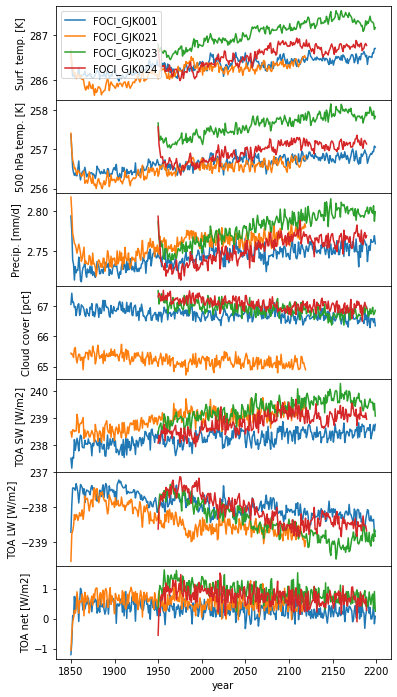

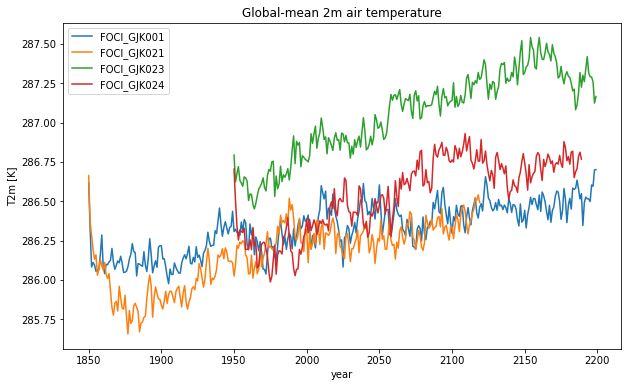

In [43]:
# Fluxes need to be scaled 
# They are stored in e.g. W/m2 * s
# So we divide by the frequency of XIOS call (usually 3hr for T95)
# To check this: 
# 1) look at the config/xios/context_ifs.xml and look for NFRHIS (might be 6 or 3)
# 2) look at the config/oifs/fort.4 and look for UTSTEP (might be 1800)
# 3) your XIOS call freq is UTSTEP * NFRHIS (e.g. 10800s = 3hr)

# This should be 1/(NFRHIS * UTSTEP)
flux_scale = 1./(6 * 60 * 60)

# Scale precip from m/s to mm/d
pr_scale = 1000. * 86400. * flux_scale

fig1, ax1 = plt.subplots(7,1,figsize=(6,12))

fig2, ax2 = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl = ds_pl_all[i]
    exp = exp_list[i]
    
    # This run had the wrong scaling
    if exp == 'foci-test-07':
        flux_scale = flux_scale * 2
        pr_scale = pr_scale * 2
    
    # Read 2m temp
    t2m = ds_sfc['2t']
    # 500 hpa temp
    t500 = ds_pl['t'].sel(pressure_levels=50000)
    # Precip
    pr = ds_sfc['tp'] * pr_scale
    # Cloud cover
    tcc = ds_sfc['tcc'] * 100
    
    # The logic in OpenIFS radiation variable names:
    # TTR = TOA Thermal Radiation, SSR = Surface Solar Radiation, etc.
    
    # TOA SW
    tsr = ds_sfc['tsr'] * flux_scale
    # TOA LW
    ttr = ds_sfc['ttr'] * flux_scale
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(t2m.lat))
    weights.name = "weights"
    
    t2m_wgt = t2m.weighted(weights)
    t2m_mean = t2m_wgt.mean(('lon','lat'))
    
    t500_wgt = t500.weighted(weights)
    t500_mean = t500_wgt.mean(('lon','lat'))
    
    pr_wgt = pr.weighted(weights)
    pr_mean = pr_wgt.mean(('lon','lat'))
    
    tcc_wgt = tcc.weighted(weights)
    tcc_mean = tcc_wgt.mean(('lon','lat'))
    
    tsr_wgt = tsr.weighted(weights)
    tsr_mean = tsr_wgt.mean(('lon','lat'))
    
    ttr_wgt = ttr.weighted(weights)
    ttr_mean = ttr_wgt.mean(('lon','lat'))
    
    # Net TOA
    toa_mean = tsr_mean + ttr_mean
    print(toa_mean)
    
    # Annual mean (otherwise seasonal cycle swamps the whole plot!)
    t2m = t2m_mean.groupby('time.year').mean('time')
    t2m.plot(ax=ax1[0],alpha=1,label=exp)
    t2m.plot(ax=ax2,alpha=1,label=exp)
    
    t500 = t500_mean.groupby('time.year').mean('time')
    t500.plot(ax=ax1[1],alpha=1)
    
    pr = pr_mean.groupby('time.year').mean('time')
    pr.plot(ax=ax1[2],alpha=1)
    
    tcc = tcc_mean.groupby('time.year').mean('time')
    tcc.plot(ax=ax1[3],alpha=1)
    
    tsr = tsr_mean.groupby('time.year').mean('time')
    tsr.plot(ax=ax1[4],alpha=1)
    
    ttr = ttr_mean.groupby('time.year').mean('time')
    ttr.plot(ax=ax1[5],alpha=1)
    
    toa = toa_mean.groupby('time.year').mean('time')
    toa.plot(ax=ax1[6],alpha=1)
    
for ax in [ax1]:
    ax[0].legend()
    ax[0].set_ylabel('Surf. temp. [K]')
    ax[1].set_ylabel('500 hPa temp. [K]')
    ax[2].set_ylabel('Precip. [mm/d]')
    ax[3].set_ylabel('Cloud cover [pct]')
    ax[4].set_ylabel('TOA SW [W/m2]')
    ax[5].set_ylabel('TOA LW [W/m2]')
    ax[6].set_ylabel('TOA net [W/m2]')
    
for ax in ax1:
    ax.set_title('')
    #ax.axis["right"].set_visible(False)
    
for ax in ax1[:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.axis["bottom"].set_visible(False)
    #ax.axis["top"].set_visible(False)

#ax1[-1].axis["top"].set_visible(False)
    
#fig1.tight_layout()
fig1.subplots_adjust(hspace=0.0) #, right=0.8, top=0.9)
fig1.savefig('global_means_oifs.pdf',format='pdf')

ax2.set_ylabel('T2m [K]')
ax2.set_title('Global-mean 2m air temperature')
ax2.legend()
fig2.savefig('plots/global_mean_2m_temp.pdf',format='pdf')

## Mixed-layer depth variability

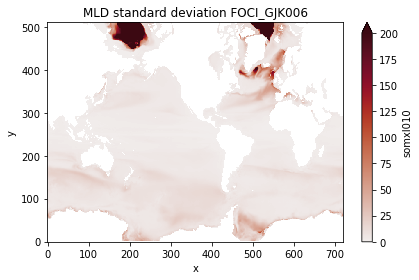

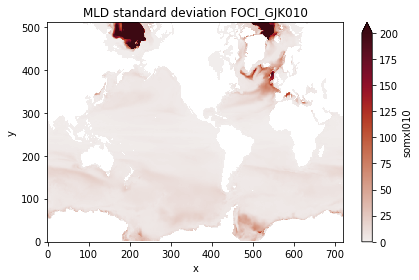

In [18]:
for i in range(0,len(exp_list)):
    
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Annual-mean MLD
    mld = ds_t['somxl010']
    
    # Standard dev
    mld_std = mld.where(mld != 0).std('time')
    
    mld_std.plot(ax=ax1, cmap=cmocean.cm.amp,
                 vmin=0, vmax=200, 
                 rasterized=True)
    
    ax1.set_title('MLD standard deviation %s' % (exp,))
    
    fig1.tight_layout()

## Deep convection

Compute deep convective volume (total volume of water where MLD>800m, i.e. deep convection). 
See definition in: Brodeau & Koenigk (2016), http://link.springer.com/10.1007/s00382-015-2736-5

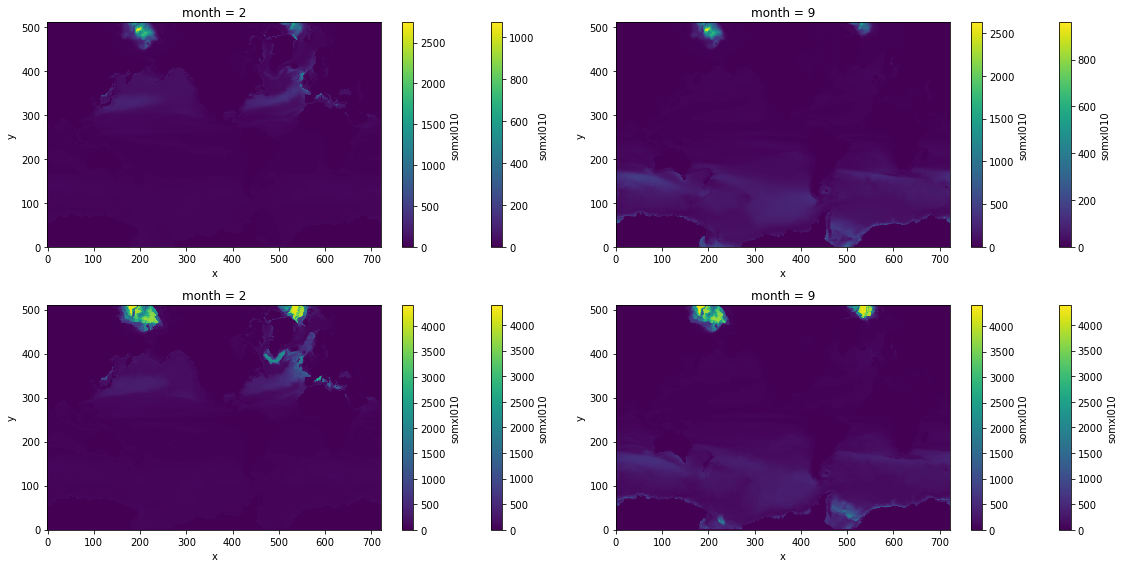

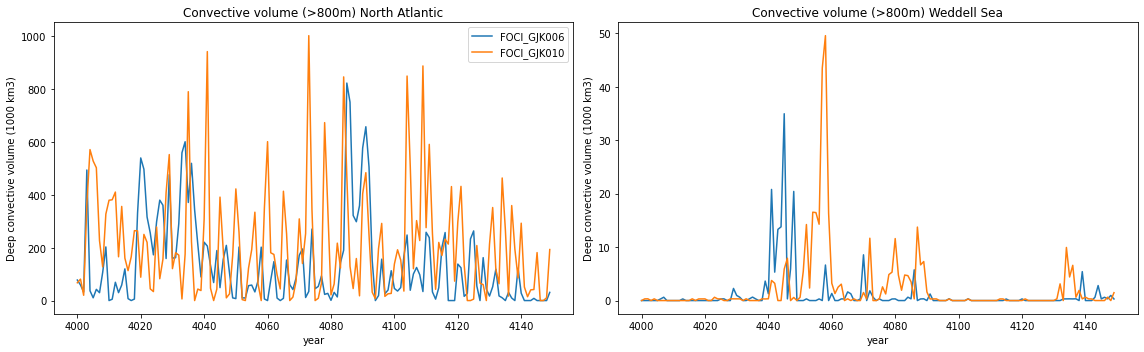

In [19]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(16,5))

for i in range(0,len(exp_list)):
    ds_t = ds_t_1m[i]
    exp = exp_list[i]
    mld = ds_t['somxl010']
    
    mld_s = mld.groupby('time.month').mean('time')
    
    # Select Feb and Sep
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[0,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[0,1])
    
    mld_s = mld.groupby('time.month').max('time')
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[1,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[1,1])
    
    # Convective volume (annual mean)
    mld_mask = mld.where(mld > 800).groupby('time.year').mean('time')
    # North Atlantic
    mld_natl = mld_mask.sel(x=slice(450,550),y=slice(350,450)) * da_orca05_area.sel(x=slice(450,550),y=slice(350,450))
    mld_natl_vol = mld_natl.sum(('x','y')) * 1e-12
    mld_natl_vol.plot(ax=axs2[0],label=exp)
    # Weddell Sea
    mld_wed = mld_mask.sel(x=slice(480,600),y=slice(50,150)) * da_orca05_area.sel(x=slice(480,600),y=slice(50,150))
    mld_wed_vol = mld_wed.sum(('x','y')) * 1e-12
    mld_wed_vol.plot(ax=axs2[1],label=exp)
    
axs2[0].set_title('Convective volume (>800m) North Atlantic')
axs2[1].set_title('Convective volume (>800m) Weddell Sea')
axs2[0].legend()
for ax in axs2:
    ax.set_ylabel('Deep convective volume (1000 km3)')

fig1.tight_layout()
fig2.tight_layout()
#fig1.savefig('mld_mean_max.png',format='png',dpi=150)
fig2.savefig('plots/deep_conv_vol.pdf',format='pdf')

## Sea ice

In [ ]:
def ice_areas(ci, hemisphere=True):
    
    w = np.cos(np.deg2rad(ci.lat))
    w.name = "weights"
    
    # Earth is 510.1 million km2
    # NH and SH are half
    if hemisphere:
        scale = 510.1/2.0
    else:
        scale = 510.1
        
    # Select Feb and Sep sea ice, add weights, and area-average
    # Unit will be million km2
    ci_feb = ci.sel(time=ci.time.dt.month.isin([2])).groupby('time.year').mean('time').weighted(w).mean(('lon','lat')) * scale
    ci_sep = ci.sel(time=ci.time.dt.month.isin([9])).groupby('time.year').mean('time').weighted(w).mean(('lon','lat')) * scale
    ci_mon = ci.groupby('time.month').mean('time').weighted(w).mean(('lon','lat')) * scale
    
    return ci_feb, ci_sep, ci_mon

fig3, axs3 = plt.subplots(2,2,figsize=(16,10))
ax3 = axs3.flat

for i, (exp, ds_i) in enumerate( zip(exp_list, ds_sfc_1m_all) ):
    
    # Sea ice fraction
    ci = ds_i['ci']
    
    prj1 = ccrs.NorthPolarStereo()
    fig1, axs1 = plt.subplots(1,2,figsize=(16,8),subplot_kw={'projection':prj1})
    prj2 = ccrs.SouthPolarStereo()
    fig2, axs2 = plt.subplots(1,2,figsize=(16,8),subplot_kw={'projection':prj2})
    
    ci_mean = ci.groupby('time.month').mean('time')
    print(ci_mean)
    # Plot Feb and Sep
    #ci_mean.sel(month=2).plot.pcolormesh(ax=axs1[0],vmin=0,vmax=1,
    #                                     cmap=cmocean.cm.ice,
    #                                     transform=ccrs.PlateCarree())
    #ci_mean.sel(month=9).plot.pcolormesh(ax=axs1[1],vmin=0,vmax=1,
    #                                     cmap=cmocean.cm.ice,
    #                                     transform=ccrs.PlateCarree())
    
    for ax in [axs1[0], axs2[0]]:
        ci_mean.sel(month=2).plot.contourf(ax=ax,levels=np.linspace(0,1,11),
                                           cmap=cmocean.cm.ice,
                                           transform=ccrs.PlateCarree())
        ax.set_title('Feb ice fraction %s' % (exp,)) 
        
    for ax in [axs1[1], axs2[1]]:
        ci_mean.sel(month=9).plot.contourf(ax=ax,levels=np.linspace(0,1,11),
                                           cmap=cmocean.cm.ice,
                                           transform=ccrs.PlateCarree())
        ax.set_title('Sep ice fraction %s' % (exp,))
    
    for ax in axs1.flat:
        ax.set_facecolor('Gainsboro')
        ax.add_feature(cartopy.feature.LAND, zorder=100)
        ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
    
    for ax in axs2.flat:
        ax.set_facecolor('Gainsboro')
        ax.add_feature(cartopy.feature.LAND, zorder=100)
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    
    fig1.tight_layout()
    #fig1.savefig('ice_mean_%s.png' % (exp,),format='png',dpi=150)
    
    ci_nh_feb, ci_nh_sep, ci_nh_mon = ice_areas(ci.sel(lat=slice(0,90)))
    ci_nh_feb.plot(ax=ax3[0], label='%s' % (exp,))
    ci_nh_sep.plot(ax=ax3[1], label='%s' % (exp,))
    
    ci_sh_feb, ci_sh_sep, ci_sh_mon = ice_areas(ci.sel(lat=slice(-90,0)))
    ci_sh_feb.plot(ax=ax3[2], label='%s' % (exp,))
    ci_sh_sep.plot(ax=ax3[3], label='%s' % (exp,))

ax3[0].legend()
ax3[1].axhline(y=7,linestyle='--',c='k')
ax3[0].axhline(y=15,linestyle='--',c='k')
ax3[2].axhline(y=3,linestyle='--',c='k')
ax3[3].axhline(y=18,linestyle='--',c='k')


#for ax in axs2:
#    ax.set_ylabel('Sea-ice extent (million km2)')
#    ax.legend()
#    
#fig2.tight_layout()
#fig2.savefig('ice_extent.pdf',format='pdf')

In [17]:
zz = z.compute()

In [ ]:
prj1 = ccrs.NorthPolarStereo()
prj2 = ccrs.SouthPolarStereo()
fig1 = plt.figure(figsize=(16,16))
axs1 = []
axs1.append( fig1.add_subplot(2,2,1,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,2,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,3,projection=prj2) )
axs1.append( fig1.add_subplot(2,2,4,projection=prj2) )
print(zz.where(zz!=np.nan))
zz.sel(month=2).plot.pcolormesh(ax=axs1[0],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[1],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=2).plot.pcolormesh(ax=axs1[2],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[3],vmin=0,vmax=1,cmap=cmocean.cm.ice)
axs1[0].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[1].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[2].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs1[3].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
for ax in axs1:
    ax.coastlines()
fig1.tight_layout()

<xarray.DataArray 'iicethic' (month: 12, y: 511, x: 722)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, .

# Radiative budget

<xarray.DataArray (time: 1000, lat: 96, lon: 192)>
dask.array<mul, shape=(1000, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2849-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
<xarray.DataArray (time: 70, lat: 96, lon: 192)>
dask.array<mul, shape=(70, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2850-07-01 06:00:00 ... 2919-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06


No handles with labels found to put in legend.


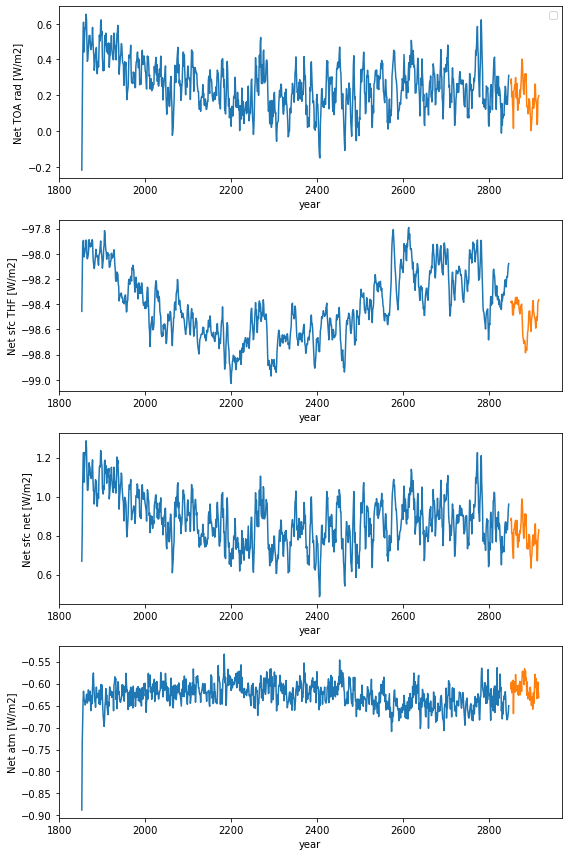

In [13]:
fscale = 1./(6 * 60 * 60.)

fig, ax = plt.subplots(4,1,figsize=(8,12))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i]
    
    # This run had the wrong scaling
    if exp == 'foci-test-07':
        fscale = fscale * 2
    
    # Net TOA
    toa = (ds_sfc['tsr'] + ds_sfc['ttr']) * fscale
    print(toa)
    # Net turb sfc 
    thf = (ds_sfc['sshf'] + ds_sfc['slhf']) * fscale
    # Net sfc rad
    sfc = (ds_sfc['ssr'] + ds_sfc['str']) * fscale
    # Net atm (pos when warming)
    net = toa - thf - sfc 
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(toa.lat))
    weights.name = "weights"
    
    toa_wgt = toa.weighted(weights)
    toa_mean = toa_wgt.mean(('lon','lat'))
    
    thf_wgt = thf.weighted(weights)
    thf_mean = thf_wgt.mean(('lon','lat'))
    
    sfc_wgt = sfc.weighted(weights)
    sfc_mean = sfc_wgt.mean(('lon','lat'))
    
    net_wgt = net.weighted(weights)
    net_mean = net_wgt.mean(('lon','lat'))
    
    # Annual mean
    toa = toa_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    toa.plot(ax=ax[0],alpha=1)
    
    thf = thf_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    thf.plot(ax=ax[1],alpha=1)
    
    sfc = sfc_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    (sfc+thf).plot(ax=ax[2],alpha=1)
    
    net = net_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    net.plot(ax=ax[3],alpha=1)
    
ax[0].legend()
ax[0].set_ylabel('Net TOA rad [W/m2]')
ax[1].set_ylabel('Net sfc THF [W/m2]')
ax[2].set_ylabel('Net sfc net [W/m2]')
ax[3].set_ylabel('Net atm [W/m2]')
fig.tight_layout()
fig.savefig('plots/radiation_equilibration.pdf',format='pdf')

## Freshwater flux

In [69]:
tot_all = []
rnf_all = []
cal_all = []
ssh_all = []
arnf_all = []

for i in range(0,len(exp_list)):
    
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i] 
    
    tot = global_tsum(ds_t['sowaflup']).compute()
    rnf = global_tsum(ds_t['runoffs']).compute()
    cal = global_tsum(ds_t['calving']).compute()
    ssh = global_tmean(ds_t['sossheig']).compute()
    
    arf = global_sum((ds_sfc['sro'] + ds_sfc['ssro']) / (6.0*60*60))
    
    tot_all.append(tot)
    rnf_all.append(rnf)
    cal_all.append(cal)
    ssh_all.append(ssh)
    arnf_all.append(arf)

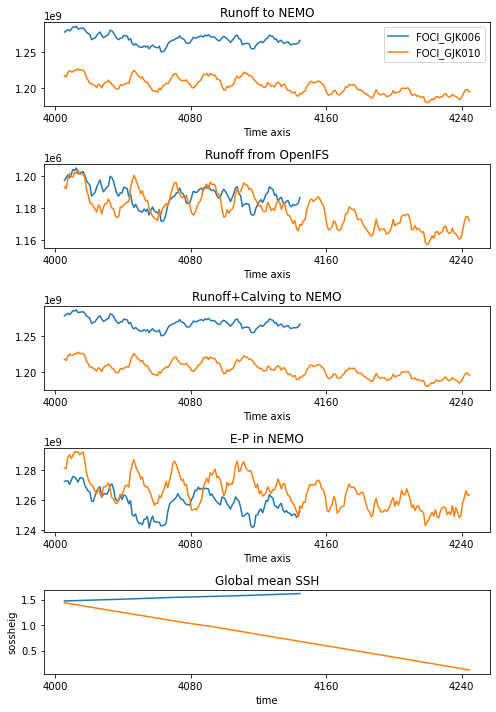

In [70]:
fig1, axs1 = plt.subplots(5,1,figsize=(7,10))
for ji,(rnf,arnf,cal,tot,ssh) in enumerate( zip(rnf_all,arnf_all,cal_all,tot_all,ssh_all) ):
    
    rnf.rolling(time=11,center=True).mean().plot(ax=axs1[0],label=exp_list[ji])
    arnf.rolling(time=11,center=True).mean().plot(ax=axs1[1],label=exp_list[ji])
    (cal+rnf).rolling(time=11,center=True).mean().plot(ax=axs1[2],label=exp_list[ji])
    (tot+rnf+cal).rolling(time=11,center=True).mean().plot(ax=axs1[3],label=exp_list[ji])
    ssh.rolling(time=11,center=True).mean().plot(ax=axs1[4],label=exp_list[ji])
    
axs1[0].legend()

axs1[0].set_title('Runoff to NEMO')
axs1[1].set_title('Runoff from OpenIFS')
axs1[2].set_title('Runoff+Calving to NEMO')
axs1[3].set_title('E-P in NEMO')
axs1[4].set_title('Global mean SSH')

fig1.tight_layout()
fig1.savefig('fw_fluxes.pdf',format='pdf')

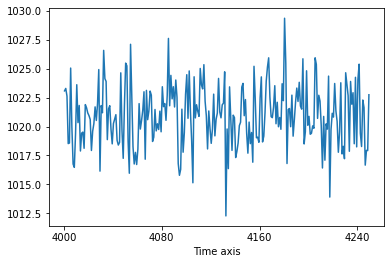

In [74]:
((rnf+cal)/arnf).plot()

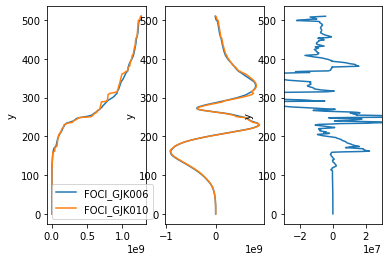

In [57]:
fig1, ax1 = plt.subplots(1,3)

for i in range(0,len(exp_list)):
    
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i] 
    
    #tot = global_zonmean(ds_t['sowaflup'].mean('time')).compute()
    #rnf = global_zonmean(ds_t['runoffs'].mean('time')).compute()
    #cal = global_zonmean(ds_t['calving']).compute()
    #ssh = global_zonmean(ds_t['sossheig']).compute()
    
    tot = (ds_t['sowaflup'].mean('time') * da_orca05_area).sum('x').compute()
    rnf = ((ds_t['runoffs'].fillna(0)+ds_t['calving'].fillna(0)).mean('time') * da_orca05_area).sum('x').compute()
    
    tot_c = tot.cumsum('y')
    rnf_c = rnf.cumsum('y')
    
    rnf_c.plot(ax=ax1[0],label=exp,y='y')
    tot_c.plot(ax=ax1[1],label=exp,y='y')
    
    if i == 0:
        _ref = rnf_c
    else:
        _diff = rnf_c - _ref
        _diff.plot(ax=ax1[2],y='y')
        ax1[2].set_xlim([-3e7,3e7])
    
ax1[0].legend()

In [75]:
cal.mean('time')

<xarray.DataArray ()>
array(630620.7067952)